# Propuesta de Investigación Corregida
Con respecto al data set de mujeres diabeticas, la investigación propone:
- 

# Cargar Datos y Descripcion de las Variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

data = pd.read_csv('diabetes.csv')

# esta variable es propia de estos datos
# no se describe como se obtuvo así que para generalizar se borrara
data.drop('DiabetesPedigreeFunction', axis=1, inplace=True)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
0,6,148,72,35,0,33.6,50,1
1,1,85,66,29,0,26.6,31,0
2,8,183,64,0,0,23.3,32,1
3,1,89,66,23,94,28.1,21,0
4,0,137,40,35,168,43.1,33,1


## Unidades de los datos
Sumamente importante pues no viene incluida como metadata en el archivo de datos, esto es de acuerdo a la pagina en que fueron obtenidos:

- Pregnancies: Cantidad de embarazos
- Glucose: Concentración de glucosa en plasma $mg/dL$
- BloodPressure: Presión distolica $mm Hg$
- SkinThickness: Triceps skin fold thickness $mm$
- Insulin: Insulina en $u U / mL$
- BMI: Indice de Masa Corporal $\frac{Kg}{m^2}$
- Age: Edad en años
- Outcome: 1 para diabetes, 0 para no diabetes

# Codigo Diabetes
Secciones:
- Limpieza de Datos
- Visualizacion de los datos y Correlaciones
- Referencias para la exploración, limpieza y aumento de datos
- Neural Networks

## Limpieza de Datos

In [158]:
# al ver los histogramas se notó que existen BMI's menores a 10
data[data.BMI < 10][:5]
# son 0, lo que significa que no son BMI's correctos, pero producto de error

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
9,8,125,96,0,0,0.0,54,1
49,7,105,0,0,0,0.0,24,0
60,2,84,0,0,0,0.0,21,0
81,2,74,0,0,0,0.0,22,0
145,0,102,75,23,0,0.0,21,0


In [159]:
# Tambien glucosa 0
# donde <117mmg/dL es no diabetico
# pero se observan de igual forma diabeticos
# podria ser indicativo de tener datos erroneos asi que tambien se limpiaran
data[data.Glucose< 10][:5]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
75,1,0,48,20,0,24.7,22,0
182,1,0,74,20,23,27.7,21,0
342,1,0,68,35,0,32.0,22,0
349,5,0,80,32,0,41.0,37,1
502,6,0,68,41,0,39.0,41,1


La insulina no tiene sentido que sea 0 para personas sin diabetes, por tanto se consideran como datos faulty;

otra cosa es el metodo utilizado para calcular la insulina que es el inmunoensayo electtroquimioluminiscente el cual entrega hasta un valor limite de $1000 \mu U/mL$, todo valor bajo ese limite es una unidad cuantitativa.
‌

In [2]:
# largo de los datos pre limpieza
pre_len = len(data)

# Lo mismo ocurrira con la insulina
# asi que limpiamos:

data.drop(data[data.BMI == 0].index, inplace=True)
data.drop(data[data.BloodPressure == 0].index, inplace=True)


# la glucosa 0 indica que esta muerto, asi que son datos faulty
data.drop(data[data.Glucose == 0].index, inplace=True)

# limpiamos la insulina faulty
data.drop(data[(data['Insulin'] == 0) & (data['Outcome'] == 1)].index, inplace=True)

post_len = len(data)

In [161]:
print(f"pre limpieza {pre_len} datos")
print(f"popst limpieza {post_len} datos")

print(f"Se eliminó el {(pre_len - post_len)*100/post_len :.2f}% de los datos")

pre limpieza 768 datos
popst limpieza 605 datos
Se eliminó el 26.94% de los datos


In [162]:
# observemos el mayor dato
data[data['Insulin'] > 800]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
13,1,189,60,23,846,30.1,59,1


### Aumento de datos

Entre la literatura aparece el indice `HOMA-IR`
de acuerdo a [8] 

"Por su simplicidad y buena correlación con mediciones más complejas de sensibilidad a la insulina, el método más utilizado es el cálculo del índice HOMA-IR (Homeostasis Model Assessment of Insulin Resistance)"

$$
\text{HOMA-IR} = \frac{\text{Glucosa} [mg/dL] \times \text{Insulina} [uU/mL]}{405}
$$

el punto de corte para definir resistencia a la insulina fue definido por Bonora et al [9] (1998) como 2.77
Sin embargo este dependerá de la población en estudio, por ejemplo en Chile el indice de corte se encontraria alrededor de 2.5 con la definición de [9]


Un globulo rojo vive 120 dias, la hemoglobina glicocilada (A1C) mide la glucosa pegada a un globulo rojo,
Por tanto al momento de tomar el examen nos entrega información de hasta 3 meses por este hecho.
Conviertiendola en un buen indiciador

‌
Sin embargo se determina por cromatografia de alta presión y no se tiene ese dato

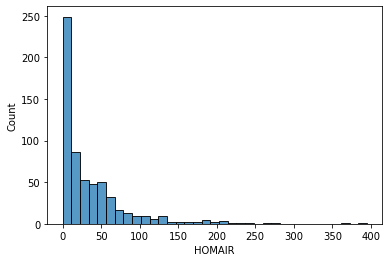

In [3]:
# Agregando el indice a los datos
data['HOMAIR'] = data['Glucose'] * data['Insulin'] / 405

sns.histplot(data.HOMAIR)
plt.show()

guardar los datos limpios y aumentados:

In [4]:
# para resetear los index despues de limpiarlos
data = data.reset_index()
data = data.drop('index', axis=1)

In [165]:
data.to_csv('diabetes_clean.csv')

## Visualizacion de los dato y Correlaciones

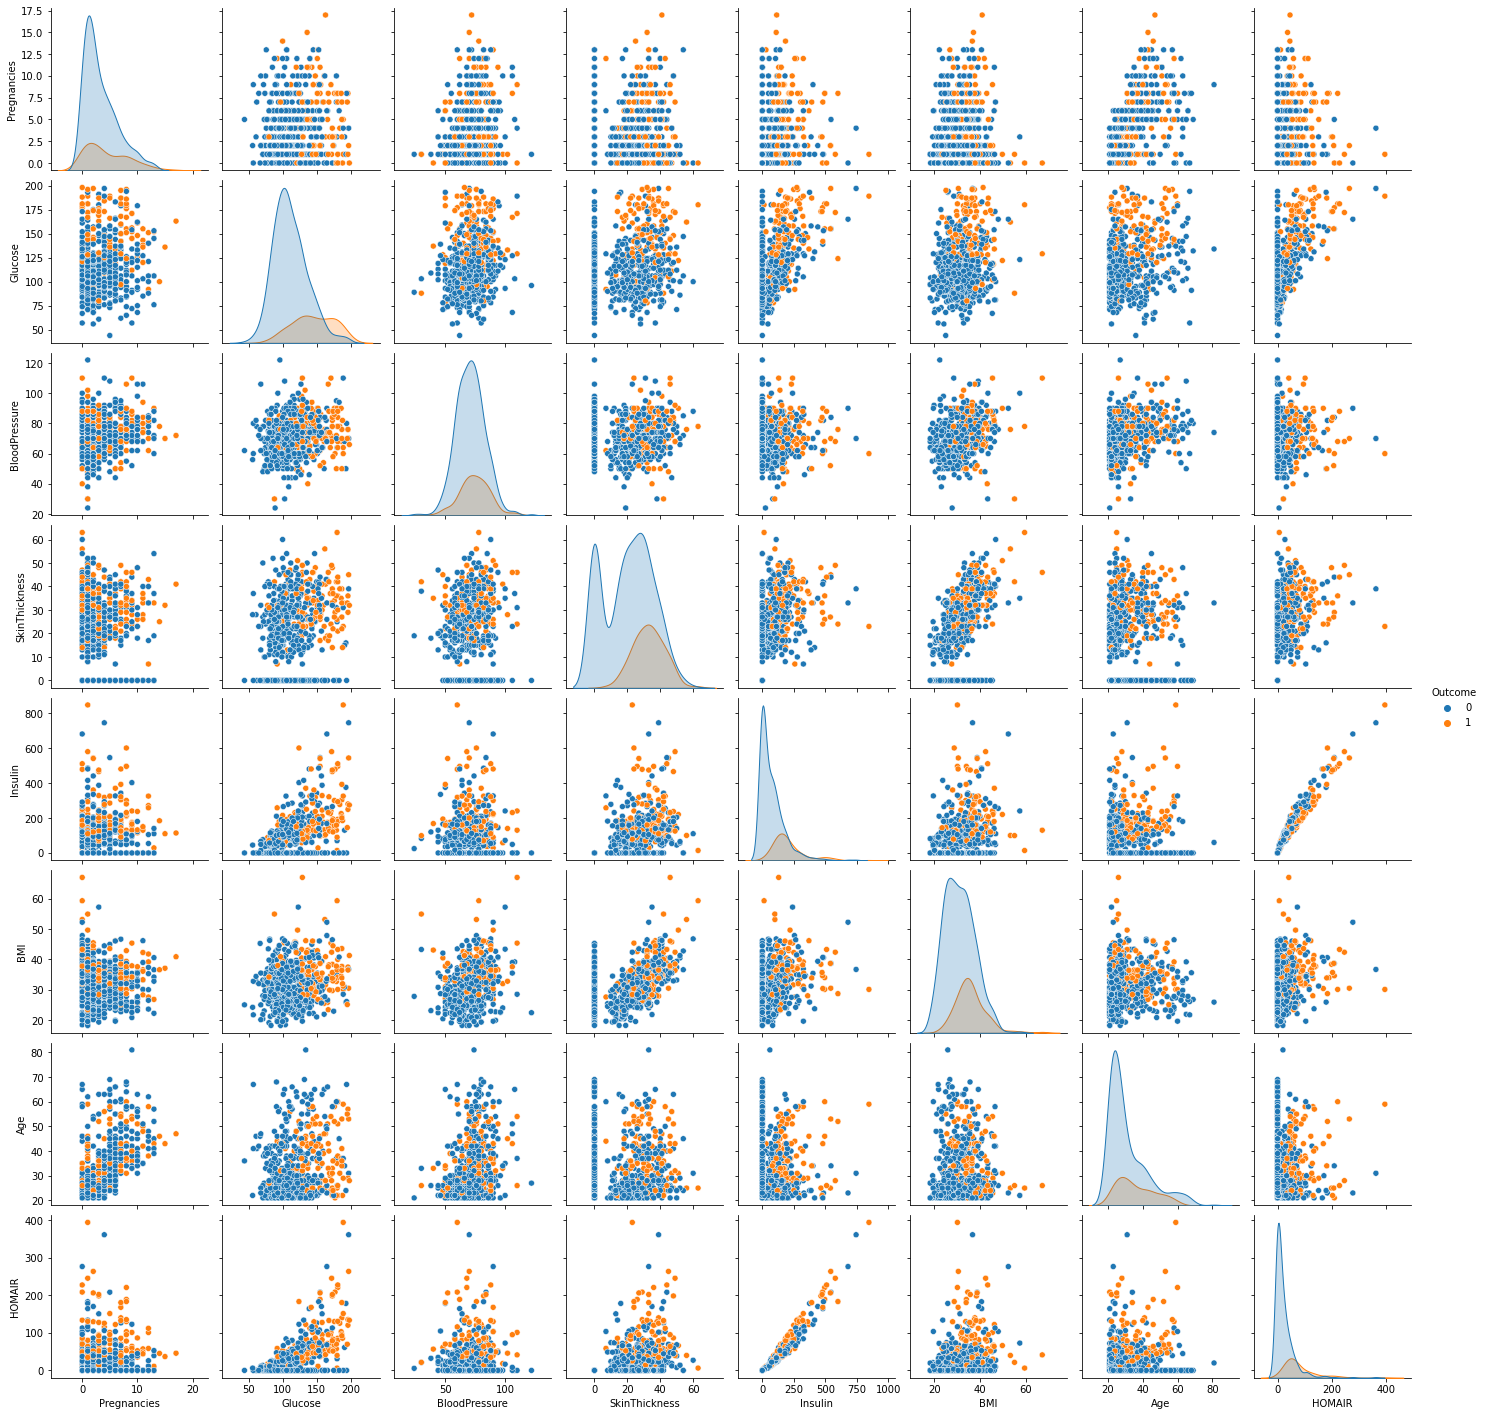

In [166]:
sns.pairplot(data, hue="Outcome")

La visualización de los datos guia la exploración del analista de los datos;
en este caso es posible observar 2 tendencias en las distribuciones (las columnas centrales que presentan los histogramas)
- La glucosa para los diabeticos se encuentra distribuida hacia la derecha
- El BMI para los diabeticos se encuentra distribuido hacia la derecha

Por tanto para comprobar si es una diferencia significativa, se realizara un test de hipotesis no parametrico llamado `Kruskal-Wallis`:

```
Test de la hipotesis nula que las medias de los grupos son iguales (funciona con más de 2 grupos)
Rechazar la hipotesis no indica cual de las muestras difiere
Tampoco entrega información a si es debido a la dispersión de los grupos o en verdad a una media poblacional distinta
```

ver [1] y [2]

In [5]:
from scipy import stats

grupo_no_diabetes = data[data['Outcome']==0]
grupo_diabetes = data[data['Outcome']==1]

In [168]:
def kruskal_wallis_median_test(grupo1, grupo2, variable, explain=True):
    """ Funcion que ordena la respuesta para el test de kruskal wallis"""

    if explain:
        print(f"Hipotesis Nula H0: Las medias de {variable} para los grupos de diabeticos y no diabeticos son iguales")
        print("Hipotesis Alternativa: Las medias de los grupos difieren.")

    p_value = stats.kruskal(grupo_diabetes[variable], grupo_no_diabetes[variable]).pvalue

    if p_value < 0.05:
        print("Tenemos evidencia contra la hipotesis nula")
        print(f"Test KW encuentra una diferencia significativa (p={p_value})")
        print(f"Indicando una diferencia de las medias de la {variable} para los dos grupos")
    elif p_value >= 0.05:
        print("No hay evidencia contra la hipotesis nula")
        print("Por tanto no podemos afirmar que existe evidencia significativa entre")
        print(f"Las medias de los grupos para la variable {variable}")
        print(f"p = {p_value}")

---Glucosa---
Hipotesis Nula H0: Las medias de Glucose para los grupos de diabeticos y no diabeticos son iguales
Hipotesis Alternativa: Las medias de los grupos difieren.
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=8.137814505541415e-27)
Indicando una diferencia de las medias de la Glucose para los dos grupos


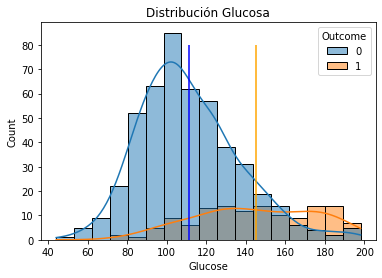

In [169]:
print("---Glucosa---")
kruskal_wallis_median_test(grupo_diabetes, grupo_no_diabetes, 'Glucose')

sns.histplot(data, x='Glucose', kde=True, hue='Outcome')

plt.vlines(grupo_diabetes.mean().Glucose, 0, 80, color='orange',label='media diabeticos')
plt.vlines(grupo_no_diabetes.mean().Glucose, 0, 80, color='blue', label='media NO diabeticos')

plt.title("Distribución Glucosa")
plt.show()

---BMI---
Hipotesis Nula H0: Las medias de BMI para los grupos de diabeticos y no diabeticos son iguales
Hipotesis Alternativa: Las medias de los grupos difieren.
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=3.936446497482462e-12)
Indicando una diferencia de las medias de la BMI para los dos grupos


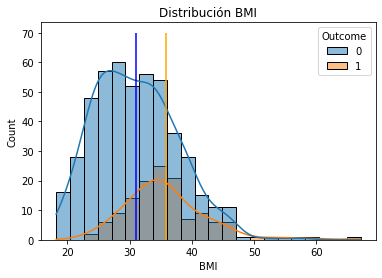

In [170]:
print("---BMI---")
kruskal_wallis_median_test(grupo_diabetes, grupo_no_diabetes, 'BMI')

sns.histplot(data, x='BMI', kde=True, hue='Outcome')

plt.vlines(grupo_diabetes.mean().BMI, 0, 70, color='orange',label='media diabeticos')
plt.vlines(grupo_no_diabetes.mean().BMI, 0, 70, color='blue', label='media NO diabeticos')

plt.title("Distribución BMI")
plt.show()

el BMI juega un rol importante para la clasificación;
puede observarse en articulos como [3]

Donde se observa una correlación del BMI con enfermedades cardiovasculares, sindrome metabolico y diabetes


In [171]:
# Y ahora el resto de las variables:
for variable_test in ['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'Age']:
    print(f"---{variable_test}----")
    kruskal_wallis_median_test(grupo_diabetes, grupo_no_diabetes, variable_test, explain=False)
    print("-------------------------------------------------------------------")


---Pregnancies----
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=0.008908283644870644)
Indicando una diferencia de las medias de la Pregnancies para los dos grupos
-------------------------------------------------------------------
---BloodPressure----
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=0.004378478255690411)
Indicando una diferencia de las medias de la BloodPressure para los dos grupos
-------------------------------------------------------------------
---SkinThickness----
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=4.099512899685257e-18)
Indicando una diferencia de las medias de la SkinThickness para los dos grupos
-------------------------------------------------------------------
---Insulin----
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=3.8645459924613624e-36)
Indicando una diferenc

Luego de este analisis se nota algo interesante;
Sobre la `Insulina`

---Insulina---
Hipotesis Nula H0: Las medias de Insulin para los grupos de diabeticos y no diabeticos son iguales
Hipotesis Alternativa: Las medias de los grupos difieren.
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=3.8645459924613624e-36)
Indicando una diferencia de las medias de la Insulin para los dos grupos


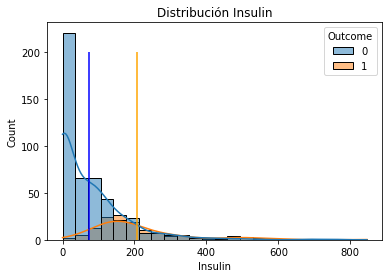

In [172]:
print("---Insulina---")
kruskal_wallis_median_test(grupo_diabetes, grupo_no_diabetes, 'Insulin')

sns.histplot(data, x='Insulin', kde=True, hue='Outcome')

plt.vlines(grupo_diabetes.mean().Insulin, 0, 200, color='orange',label='media diabeticos')
plt.vlines(grupo_no_diabetes.mean().Insulin, 0, 200, color='blue', label='media NO diabeticos')

plt.title("Distribución Insulin")
plt.show()

---HOMA-IR--
Hipotesis Nula H0: Las medias de HOMAIR para los grupos de diabeticos y no diabeticos son iguales
Hipotesis Alternativa: Las medias de los grupos difieren.
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=2.5242096902101396e-40)
Indicando una diferencia de las medias de la HOMAIR para los dos grupos


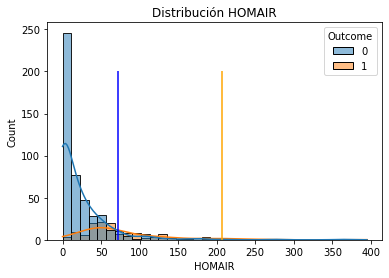

In [192]:
print("---HOMA-IR--")
kruskal_wallis_median_test(grupo_diabetes, grupo_no_diabetes, 'HOMAIR')

sns.histplot(data, x='HOMAIR', kde=True, hue='Outcome')

plt.vlines(grupo_diabetes.mean().Insulin, 0, 200, color='orange',label='media diabeticos')
plt.vlines(grupo_no_diabetes.mean().Insulin, 0, 200, color='blue', label='media NO diabeticos')

plt.title("Distribución HOMAIR")
plt.show()

Existe una diferencia visible en la distribución, pero debido a la distribución de los datos u otros factores como la dispersión podria ser opacada.
Se apoyo en la literatura para expandir más los conocimientos del area, ver sección de referencia.

Se puede concluir que:

```
Las medias de los datos no son iguales para grupos de diabeticas y no diabeticas, por lo tanto es posible utilizar indicadores visuales como edad, BMI y embarazos para arrojar un buen primer estimado;
puesto que en promedio cualquiera de estas variables tendran una diferencia en cuanto a la media con respecto a diabeticos o no diabeticos
```

## Referencias para la exploración, limpieza y aumento de datos

[1]
W. H. Kruskal & W. W. Wallis, “Use of Ranks in One-Criterion Variance Analysis”, Journal of the American Statistical Association, Vol. 47, Issue 260, pp. 583-621, 1952.

[2]
https://en.wikipedia.org/wiki/Kruskal-Wallis_one-way_analysis_of_variance

[3] 
Yoo, B., Nam, H., In Koo Hwang, & Park, Y.-M. (2017). Correlation of Cardiovascular Risk Factors with Central Obesity and Multiple Body Mass Index in Korea. 38(6), 338–338. https://doi.org/10.4082/kjfm.2017.38.6.338

[4]
CDC. (2023, February 28). Diabetes Tests. Centers for Disease Control and Prevention. https://www.cdc.gov/diabetes/basics/getting-tested.html#:~:text=A%20fasting%20blood%20sugar%20level,higher%20indicates%20you%20have%20diabetes.

[5]
Ortiz, J., & Franco Romaní. (2018). Índice triglicéridos/colesterol de alta densidad y perfil lipídico en adolescentes escolares de una región andina del Perú. https://doi.org/10.15381/anales.v79i4.15634

‌[6]
Índice triglicéridos/HDL-colesterol: en una población de adolescentes sin factores de riesgo cardiovascular. (2020). Alanrevista.org. https://www.alanrevista.org/ediciones/2012/2/art-10/

‌[7]
Sujatha, R., & Kavitha, S. (2017). Atherogenic indices in stroke patients: A retrospective study. Iranian Journal of Neurology, 16(2), 78–82. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5526781/

‌[8]
N Fernando Carrasco, Galgani, E., & J. Marcela Reyes. (2013). Síndrome de resistencia a la insulina. estudio y manejo. 24(5), 827–837. https://doi.org/10.1016/s0716-8640(13)70230-x

‌[9]
Bonora, E., Kiechl, S., Johann Willeit, Friedrich Oberhollenzer, Egger, G., Targher, G., Alberiche, M., Bonadonna, R. C., & Muggeo, M. (1998). Prevalence of insulin resistance in metabolic disorders: the Bruneck Study. 47(10), 1643–1649. https://doi.org/10.2337/diabetes.47.10.1643

‌[10]
Baco, F. (n.d.). Hemoglobina glucosilada o Hb A1c. https://www.galenusrevista.com/IMG/pdf/Hemoglobina.pdf

‌[11]
Guía Clínica 2010 Diabetes Mellitus tipo 2. (n.d.). https://www.minsal.cl/portal/url/item/72213ed52c3e23d1e04001011f011398.pdf

[12]
Algoritmo diagnóstico de la diabetes mellitus tipo 2. (2023). Elsevier.es. https://www.elsevier.es/es-revista-endocrinologia-nutricion-12-pdf-13098543

‌
[13]
www.ilogica.cl, I. (2018, May 8). Prevención de Diabetes Mellitus Tipo 2, detección y manejo inicial de prediabetes. Escuela de Medicina. https://medicina.uc.cl/publicacion/prevencion-diabetes-mellitus-tipo-2-deteccion-manejo-inicial-prediabetes/

‌
[14]
ALAD. (n.d.). https://www.revistaalad.com/guias/5600AX191_guias_alad_2019.pdf

[15]
Insulina Insulina (CLIA) Información para pedidos Uso previsto. (n.d.). https://desego.com/wp-content/uploads/2021/06/Reactivo-Insulin-2X-50.pdf

‌
‌

### PCA | Data Segmentation Hypothesis
Existe una posible segmentación en los datos en base a PCA con las variables:
- Edad
- BMI
- Pregnancies

Esta sección se encarga de observar si mediante el uso de principal component analysis es posible separar los datos en grupos bien definidiso en un espacio de bajas dimensiones;
entiendase como una aproximación basica para observar la capacidad de estas variables de describir a un paciente


In [6]:
def PCA_KNN(X,y,name,n_neighbors):
    # Split de train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=42
    )

    # Reduce dimension to 2 with PCA
    pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=42))
    pca.fit(X_train, y_train);

    # KNN
    knn = KNeighborsClassifier(n_neighbors=n_neighbors);

    # KKN fit
    knn.fit(pca.transform(X_train), y_train)
    # accurarcy del KNearestN
    acc_knn = knn.score(pca.transform(X_test), y_test)

    # Transformacion a 2D
    X_embedded = pca.transform(X)

    sc = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
    plt.colorbar(sc)
    plt.title(
        "{}\nTest accuracy = {:.2f}".format(name,acc_knn)
        )
    plt.show()

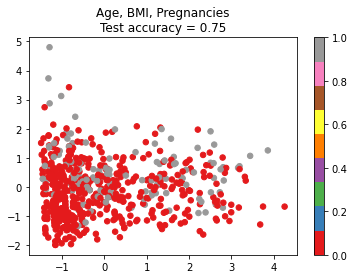

In [12]:
X, y = data[['Age','BMI','Pregnancies']], data['Outcome']
PCA_KNN(X,y,name='Age, BMI, Pregnancies',n_neighbors=2)


Como se indico con el test estadistico, existe en promedio una diferencia de los datos de diabeticas y no diabeticas, utilizar el algoritmo de PCA nos indica que estas variables tienen suficiente información como para entregar un buen primer estimado

Conclusión: Utilizando unicamente las variables visuales es posible predecir la diabetes con un 60%; es una precisión baja y podria ser producto de estar trabajando unicamente con el BMI como un indicador

Ahora a buscar que variables contienen menos cantidad de información, 
iterativamente quitamos una de las 3 para el algoritmo de PCA

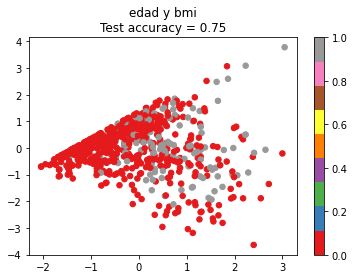

In [13]:
X, y = data[['Age','BMI']], data['Outcome']
PCA_KNN(X,y,name='edad y bmi',n_neighbors=2)

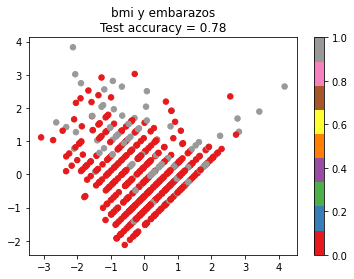

In [14]:
X, y = data[['BMI','Pregnancies']], data['Outcome']
PCA_KNN(X,y,name='bmi y embarazos',n_neighbors=2)

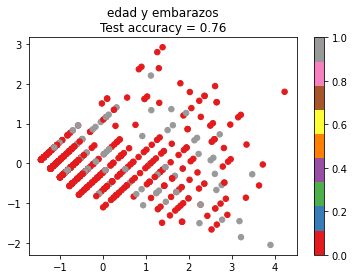

In [15]:
X, y = data[['Age','Pregnancies']], data['Outcome']
PCA_KNN(X,y,name='edad y embarazos',n_neighbors=2)

Este analisis estadistico indica que:

```
BMI, Edad y Embarazos que son variables faciles de medir indican una correlación importante con la prevalencia del diabetes, gracias a utilizar PCA, es posible inferir que estas variables poseen información importante para un primer estimado

Descontando una de estas variables a la vez del algoritmo de PCA es posible observar que no hay mucha perdida de información sobre diabetes o no; osea que puede existir algun tipo de correlación entre ellas

una teoria es que cualquiera de estas variables independientemente pueden entregar un buen estimado sobre la presencia de diabetes o no
```

# Neural Networks

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

data = pd.read_csv('diabetes_clean.csv', index_col=0)

print(len(data))
data.head()

605


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome,HOMAIR
0,1,85,66,29,0,26.6,31,0,0.000000
1,1,89,66,23,94,28.1,21,0,20.656790
2,0,137,40,35,168,43.1,33,1,56.829630
3,5,116,74,0,0,25.6,30,0,0.000000
4,3,78,50,32,88,31.0,26,1,16.948148


In [17]:
# cosas de Red Neuronal

import torch.nn as nn
import torch

from torch.optim import SGD, Adam
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.init as init

from sklearn.metrics import confusion_matrix

Las técnicas de normalización se utilizan para escalar y transformar las características (variables) de un conjunto de datos con el objetivo de que todas las características tengan la misma escala o distribución. Esto es útil para evitar que una característica domine sobre las demás debido a su rango o magnitud.

- The maximum absolute scaling: Esta técnica escala los valores de las características al dividir cada valor por el máximo valor absoluto encontrado en el conjunto de datos. Esto asegura que todos los valores estén en el rango de -1 a 1. Es una técnica útil cuando se desea mantener la relación de magnitud entre las características, pero se elimina la información sobre la distribución original.

- The min-max feature scaling: En esta técnica, los valores de las características se escalan al rango específico, generalmente entre 0 y 1. Se calcula restando el valor mínimo de cada característica y dividiendo por la diferencia entre el valor máximo y el valor mínimo. Esta técnica preserva la relación de magnitud y la distribución relativa de los datos originales.

- The z-score method: Esta técnica también se conoce como estandarización. Se basa en la transformación de los valores de las características para que tengan una media cero y una desviación estándar de uno. Para lograr esto, se resta la media de cada característica y se divide por su desviación estándar. La estandarización es útil cuando se desea que los datos tengan una distribución normal con media cero y varianza uno.

- The robust scaling: Esta técnica está diseñada para manejar datos con valores atípicos (outliers). Utiliza una mediana y una medida de dispersión robusta, como el rango intercuartil (IQR), en lugar de la media y la desviación estándar. Los valores se escalan restando la mediana y dividiendo por el IQR. Esto hace que la técnica sea más resistente a los valores atípicos y adecuada para conjuntos de datos con distribuciones no normales.


In [18]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Min Max Scaler
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Max Abs Scaler
abs_scaler = MaxAbsScaler()
abs_scaler.fit(data)
scaled_data = abs_scaler.transform(data)
df_scaled = pd.DataFrame(scaled_data, columns=data.columns)

# Standard Scaler
std_scaler = StandardScaler()
df_std = pd.DataFrame(std_scaler.fit_transform(data), columns=data.columns)

# Robust Scaler
scaler = RobustScaler()
df_robust = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)


# Tenemos así los datos
normalized_data = {'norm': df_norm,
    'scaled': df_scaled, 'standarized': df_std, 'robust': df_robust}


es posible ver la diferencia visualmente de las escalas,
eventualmente se desea usar estas 4 normalizaciones de los datos con las distintas configuraciones de la red de manera de encontrar los hiperparametros optimos

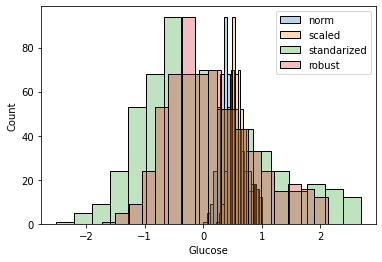

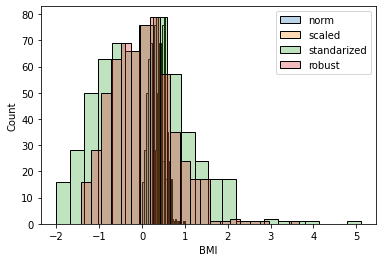

In [19]:
keys = ['norm', 'scaled', 'standarized', 'robust']

for k in keys:
    X = normalized_data[k].Glucose
    sns.histplot(X,label=k,alpha=0.3)
plt.legend()
plt.show()

for k in keys:
    X = normalized_data[k].BMI
    sns.histplot(X,label=k,alpha=0.3)
plt.legend()
plt.show()

In [20]:
# A partir de un grupo de datos entregados, obtener entrenamiento, test y validacion
def get_data(data_selected, p_train=0.8, p_validation=0.5, random_state=42):
    """
    Input: pandas dataset con columna de Outcome como targets

    Output: Pytorch Tensors
        X_train, X_test, X_valid, y_train, y_test, y_valid

    p_train es el porcentaje de datos a dejar en entrenamiento
    luego de los datos restantes
    p_validation indica el porcentaje de esos datos restantes para validacion

    random_state se refiere al estado aleatorio para decidir que valores tomar

    """
    # Normalmente separamos los features de los targets
    X, y = data_selected.drop(['Outcome'], axis=1), data_selected['Outcome']


    # Separar los datos
    X, y = torch.Tensor(X.values), torch.Tensor(y.values)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=p_train, random_state=42
        )

    X_test, X_valid, y_test, y_valid = train_test_split(
        X_test, y_test, test_size=p_validation, random_state=random_state
        )

    return X_train, X_test, X_valid, y_train, y_test, y_valid

sobre funciones de activación

Text(0.5, 1.0, 'Funcion activacion: LeakyReLU')

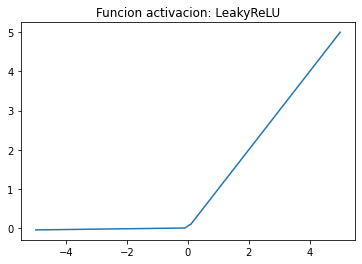

In [186]:
x = torch.linspace(-5,5,50)
lrelu = nn.LeakyReLU()
plt.plot(x, lrelu(x))
plt.title("Funcion activacion: LeakyReLU")

Text(0.5, 1.0, 'Sigmoide -> Probabilidad')

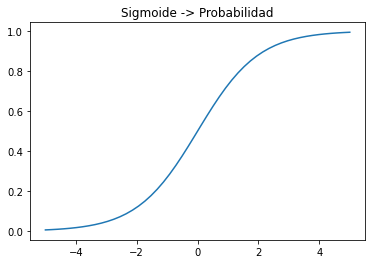

In [187]:
x = torch.linspace(-5,5,50)
sigmoid = nn.Sigmoid()
plt.plot(x, sigmoid(x))
plt.title("Sigmoide -> Probabilidad")

La red que usa toda la información requerira que tengamos los datos reescalados para que todos tengan igual importancia, osea que sea objetiva al leer la información

In [21]:
# Para el primer entranmeinto, usare los standar
data_selected = normalized_data['standarized']
# para no normalizar los labels
data_selected['Outcome'] = data['Outcome']

# Luego se separan
X_train, X_test, X_valid, y_train, y_test, y_valid = get_data(data_selected, 
    p_train=0.6, p_validation=0.6)

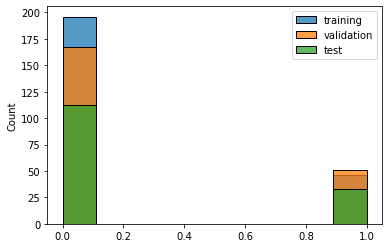

In [27]:
# Este grafico es para ver si la separación tiene un buen equilibrio
sns.histplot(y_train, label='training')
sns.histplot(y_valid, label='validation')
sns.histplot(y_test, label='test')
plt.legend()
plt.show()

Creamos la red, puede parecer una clase muy grande, previamente se encontraba repartida en el codigo lo cual volvia las cosas más desordenadas, la arquitectura es:
- Creación de la red
- metodo de forward
- fit
    - separación en mini batches
    - generación de perdidas por test de batches y por validation data
    - compración de casos que podrian indicar overfitting que detienen el fit


In [92]:
class CompleteNetwork(nn.Module):
    def __init__(self, input_size, max_depth, width_multiplier=3):
        super(CompleteNetwork, self).__init__()
        
        self.input_size = input_size
        self.max_depth = max_depth
        self.size = input_size * width_multiplier

        funcion_activacion_1 = nn.ReLU()
        funcion_activacion_2 = nn.Tanh()

        # Construcción de las capas
        layers = []

        layer = nn.Linear(self.input_size, self.size)
        init.xavier_uniform_(layer.weight)  # Inicialización de Xavier
        layers.append(layer)
        layers.append(funcion_activacion_1)
        
        # Se expanden
        depth = max_depth // 2
        for i in range(1, depth + 1):
            layer = nn.Linear(self.size * i, self.size * (i + 1))
            init.xavier_uniform_(layer.weight)  # Inicialización de Xavier
            layers.append(layer)
            layers.append(funcion_activacion_1)

        for i in range(depth, 0, -1):
            layer = nn.Linear(self.size * (i + 1), self.size * (i))
            init.xavier_uniform_(layer.weight)  # Inicialización de Xavier
            layers.append(layer)
            layers.append(funcion_activacion_2)

        # hasta acabar con solo una sigmoide
        layer = nn.Linear(self.size * (i), 1)
        init.xavier_uniform_(layer.weight)  # Inicialización de Xavier
        layers.append(layer)
        layers.append(nn.Sigmoid())

        self.layers = nn.Sequential(*layers)

    def forward(self, X):
        return self.layers(X)

    def fit(self, X_train, y_train, X_valid, y_valid, 
        loss_fn, optimizer, scheduler, n_epochs, batch_size,
        loss_fn2=None, loss_fn2_weight=0.5, debug=True):
        loss_array_training = []
        loss_array_validation = []

        self.loss_fn2 = loss_fn2
        self.loss2_weight = loss_fn2_weight

        min_loss = 1e20
        epsilon = 1e-5
        running_loss = 0
        self.train()

        for epoch in range(n_epochs):
            for i in range(0, len(X_train), batch_size):
                Xbatch = X_train[i:i+batch_size]
                target = y_train[i:i+batch_size].reshape(-1, 1)
                output = self(Xbatch)

                loss = loss_fn(output, target)

                if self.loss_fn2: # funcion de perdida extra
                    loss += self.loss2_weight * self.loss_fn2(output, target)

                running_loss += float(loss.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            loss_array_training.append(running_loss)

            with torch.no_grad():
                y_pred = self(X_valid)
                loss_validation = loss_fn(y_pred, y_valid.reshape(-1, 1))
                loss_array_validation.append(loss_validation.detach())

            if debug:
                if epoch % 5 == 0:
                    print(f'epoch {epoch}, loss epoch {loss}')

            if float(loss_validation.detach()) > float(running_loss):
                print('break por overfitting')
                break
            elif np.abs(float(running_loss) - min_loss) < epsilon:
                print('break por loss estatico')
                break

            scheduler.step()
            min_loss = np.minimum(running_loss, min_loss)
            running_loss = 0

        return loss_array_training, loss_array_validation

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Uso del código
n_features = 8
max_depth = 2
width_multiplier = 2

model = CompleteNetwork(n_features, max_depth, width_multiplier)

total_params = count_parameters(model)
print("Número total de parámetros: ", total_params)


Número total de parámetros:  1233


epoch 0, loss epoch 0.01679881289601326
epoch 5, loss epoch 0.012664434500038624
epoch 10, loss epoch 0.006271470803767443
epoch 15, loss epoch 0.02671745978295803
epoch 20, loss epoch 0.004781088326126337
epoch 25, loss epoch 0.005030581261962652
epoch 30, loss epoch 5.732856152462773e-05
epoch 35, loss epoch 0.00014225146151147783
break por overfitting


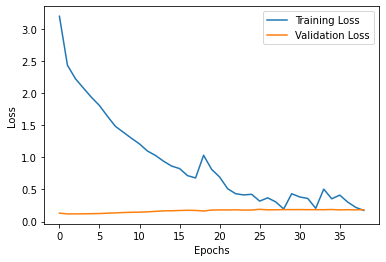

In [30]:
# ---- Training  -----
lr = 5e-3
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=100)

n_epochs = 190
batch_size = 11

loss_array_training, loss_array_validation = model.fit(X_train, y_train, X_valid, y_valid, 
    loss_fn, optimizer, scheduler, n_epochs, batch_size)

# Visualizar los errores
plt.plot(loss_array_training, label='Training Loss')
plt.plot(loss_array_validation, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
# Funciones de Visualización
def observe_predictions(X_test, y_test, model):
    # Obtener los índices que ordenan y_test en orden ascendente
    sorted_indices = np.argsort(y_test)

    # Ordenar y_test y X_test utilizando los índices obtenidos
    s_y_test = y_test[sorted_indices]
    s_X_test = X_test[sorted_indices]

    # como se ve el testing
    plt.scatter(np.arange(len(s_X_test)),model(s_X_test).detach(), label='model prediction', alpha=0.5)
    plt.plot(s_y_test, label='target', color='orange')
    plt.legend()
    plt.show()

    # como se ve el testing BAR PLOT
    sns.histplot(s_y_test, label='target', color='orange', bins=10)
    # probar con disintos bin size aqui:
    sns.histplot(model(s_X_test).detach(), label='model prediction', bins=10)
    plt.legend()
    plt.show()

def calculate_accuracy_and_false_negatives(model, X_test, y_test):
    # Obtener predicciones del modelo
    y_pred = model(X_test)
    
    # Convertir predicciones en etiquetas binarias
    y_pred_binary = (y_pred >= 0.5).float()
    
    # Calcular precisión del modelo en términos de un porcentaje
    accuracy = (y_pred_binary == y_test).float().mean() * 100
    
    # Calcular porcentaje de falsos negativos
    false_negatives = ((y_pred_binary == 0) & (y_test == 1)).float().mean() * 100
    
    return accuracy, false_negatives

def model_confusion_matrix(X_test, y_test, model):

    # Obtener los índices que ordenan y_test en orden ascendente
    sorted_indices = np.argsort(y_test)

    # Ordenar y_test y X_test utilizando los índices obtenidos
    s_y_test = y_test[sorted_indices]
    s_X_test = X_test[sorted_indices]

    predicted_labels = model(s_X_test).detach().numpy().round()
    cm = confusion_matrix(s_y_test, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    plt.xlabel("Predicción de Labels")
    plt.ylabel("Verdaderas Labels")
    plt.title("Matrix de Confusión")
    plt.show()

Precisión: 64.47%
Porcentaje de falsos negativos: 17.42%


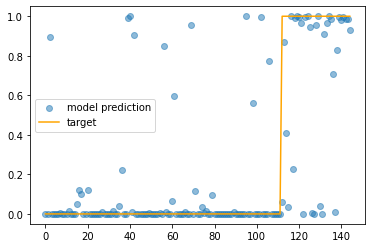

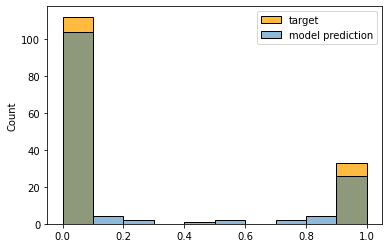

In [38]:
accuracy, false_negatives = calculate_accuracy_and_false_negatives(model, X_test, y_test)
print("Precisión: {:.2f}%".format(accuracy))
print("Porcentaje de falsos negativos: {:.2f}%".format(false_negatives))

observe_predictions(X_test, y_test, model)

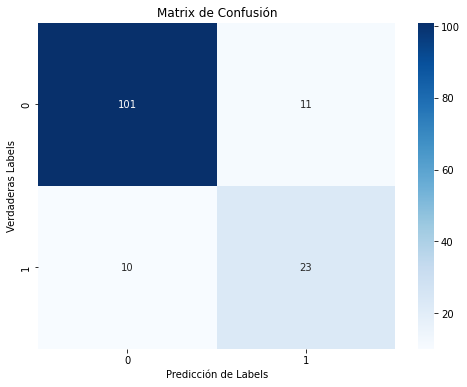

In [39]:
model_confusion_matrix(X_test, y_test, model)

en estos casos hemos de considerar unos terminos extras en el contexto medico:

- Especificidad: También conocida como tasa de verdaderos negativos, representa la proporción de casos negativos reales que el modelo clasifica correctamente. En el contexto de la detección de diabetes, la especificidad indica la capacidad del modelo para identificar correctamente a los pacientes que no tienen diabetes. Se calcula como:

$$
\text{Especificidad} = \frac{\text{Verdaderos negativos}}{\text{Verdaderos negativos} + \text{Falsos positivos}}
$$

- Sensitividad: También conocida como tasa de verdaderos positivos, representa la proporción de casos positivos reales que el modelo clasifica correctamente. En el contexto de la detección de diabetes, la sensibilidad indica la capacidad del modelo para identificar correctamente a los pacientes que realmente tienen diabetes. Se calcula como:

$$
\text{Sensibilidad} = \frac{\text{Verdaderos positivos}}{\text{Verdaderos positivos} + \text{Falsos negativos}}
$$


# Mejorando el Modelo

Consideremos el caso en que los doctores y la mayoria de profesionales han muerto debido a una toma de poder por parte de las maquinas, somos un analista que tuvo la suerte de cursar el ramo de inteligencia artificial por lo que trabajamos dentro de una de sus granjas de trabajadores humanos;
este modelo es lo unico que tenemos para predecir el diabetes en estas personas, así que lo peor que podria suceder seria tener un falso negativo, osea que el modelo prediga que no hay diabetes mientras que la persona sufre de la condición.

Por tanto es necesario considerar como se soluciona este problema y podemos inspirarnos en Physics Informed Neural Networks que desean que partes del modelo cumplan leyes de la fisica, como una ecuación del fenomeno subyacente

Maziar Raissi, Paris Perdikaris, and George Em Karniadakis, Physics Informed Deep Learning, https://maziarraissi.github.io/PINNs/

esto no hace más que resaltar la capacidad de control que tenemos agregando terminos a la funcion de perdida de manera ingeniosa:

previamente se intento usar:

```python
TN = torch.logical_and(y_true == 0, y_pred < 0.5)
TP = torch.logical_and(y_true == 1, y_pred >= 0.5)

FP = torch.logical_and(y_true == 0, y_pred >= 0.5)
FN = torch.logical_and(y_true == 1, y_pred < 0.5)
```

sin embargo las operaciones logicas no son diferenciables por lo que el modelo no podria tomarlas en cuenta en los algoritmos de optimización.

Entonces se propusó lo siguiente:

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Esta función es la que escribí al comienzo pero no entrega buenos resultados
def binary_recall_specificity(y_true, y_pred, recall_weight, spec_weight):
    
    # Calcular los valores de TN, TP, FP
    TN = torch.sum((1 - y_true) * F.sigmoid(1 - y_pred))
    TP = torch.sum(y_true * F.sigmoid(y_pred))
    FP = torch.sum((1 - y_true) * F.sigmoid(y_pred))

    # Calcular el valor de FN utilizando una aproximación suave
    FN = torch.sum(y_true * (1 - F.sigmoid(y_pred)))
    specificity = TN / (TN + FP + 1e-7)
    recall = TP / (TP + FN + 1e-7)

    return 1.0 - (recall_weight * recall + spec_weight * specificity)


class CustomLoss(nn.Module):
    def __init__(self, recall_weight, spec_weight):
        super(CustomLoss, self).__init__()
        self.recall_weight = recall_weight
        self.spec_weight = spec_weight

    def forward(self, y_true, y_pred):
        return binary_recall_specificity(y_true, y_pred, self.recall_weight, self.spec_weight)

# Así que la simplifiqué a esta expresión
class CustomLossDif(nn.Module):
    def __init__(self):
        super(CustomLossDif, self).__init__()

    def forward(self, y_pred, y_true):
        # Aproximar los falsos negativos de manera diferenciable
#        return torch.sum(torch.min(y_true, 1 - y_pred))

        FN = torch.sum(y_true * (1 - y_pred))

        return FN


In [48]:
false_neg_loss = CustomLossDif()

epoch 0, loss epoch 0.39295437932014465
epoch 5, loss epoch 0.3654029965400696
epoch 10, loss epoch 0.29608258605003357
epoch 15, loss epoch 0.24522405862808228
epoch 20, loss epoch 0.16624313592910767
epoch 25, loss epoch 0.13898853957653046
epoch 30, loss epoch 0.12038112431764603
epoch 35, loss epoch 0.10036107897758484
epoch 40, loss epoch 0.08959892392158508
epoch 45, loss epoch 0.0741783082485199
epoch 50, loss epoch 0.06136041507124901
epoch 55, loss epoch 0.05369774252176285
epoch 60, loss epoch 0.04221636429429054
epoch 65, loss epoch 0.037383679300546646
epoch 70, loss epoch 0.031191958114504814
epoch 75, loss epoch 0.026576288044452667
epoch 80, loss epoch 0.024018704891204834
epoch 85, loss epoch 0.020484326407313347
epoch 90, loss epoch 0.019303904846310616
epoch 95, loss epoch 0.017406968399882317
epoch 100, loss epoch 0.016408175230026245
epoch 105, loss epoch 0.016671255230903625
epoch 110, loss epoch 0.014643779024481773
epoch 115, loss epoch 0.013938001357018948
epoch

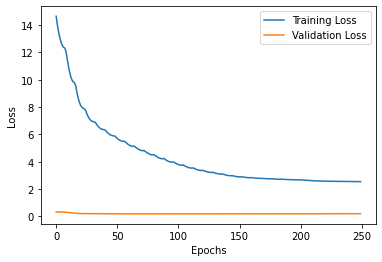

In [53]:
# Instanciar el modelo con los mismos hiperparametros
n_features = 8
max_depth = 2
width_multiplier = 2

model = CompleteNetwork(n_features, max_depth, width_multiplier)

# De esa manera el training ahora es:
# ---- Training  -----
lr = 5e-4

loss_fn = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                        T_0 = 8,
                                        T_mult = 1,
                                        eta_min = 1e-8)

n_epochs = 250
batch_size = 11

# ---- Fitting -----
loss_array_training, loss_array_validation = model.fit(X_train, y_train, X_valid, y_valid, 
    loss_fn, optimizer, scheduler, n_epochs, batch_size, loss_fn2=binary_loss, loss_fn2_weight=0.2)

# Visualizar los errores
plt.plot(loss_array_training, label='Training Loss')
plt.plot(loss_array_validation, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Precisión: 60.71%
Porcentaje de falsos negativos: 15.85%


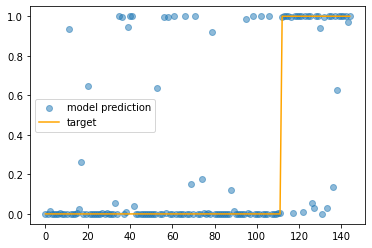

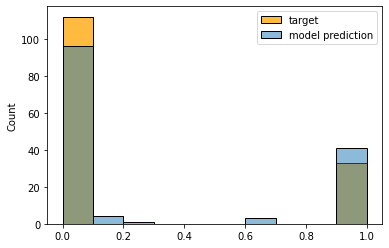

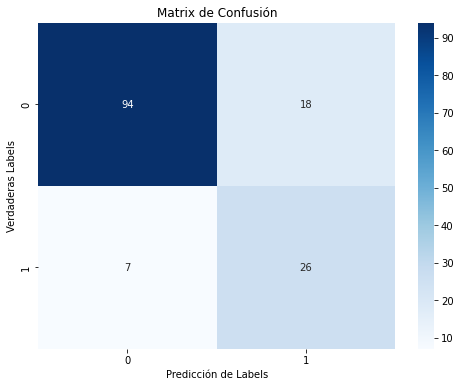

In [55]:
accuracy, false_negatives = calculate_accuracy_and_false_negatives(model, X_test, y_test)
print("Precisión: {:.2f}%".format(accuracy))
print("Porcentaje de falsos negativos: {:.2f}%".format(false_negatives))

observe_predictions(X_test, y_test, model)
model_confusion_matrix(X_test, y_test, model)

Esta funcion de perdida provoca que el modelo prefiera predecir más veces el diabetes a pesar de que la mayoria de los datos son de no diabeticos, lo cual hizo que disminuyeran los Falsos Negativos

esa adición le ha salvado la vida a 6 personas en el complejo de granjas humanas,
excelente trabajo :)

Si bien se ha observado una perdida de precisión total, es preferible que si dice que no hay diabetes, tenga una mayor seguridad, esto se puede observar en modelos como los criminalisticos que no se desea predecir culpabilidad para una persona inocente (falso positivo)


### BMI, Edad, Embarazos
Ahora observemos que tal se comportan estas 3 variables para predecir la diabetes,
recordemos que de acuerdo al analisis de PCA estas 3 poseen una cantidad de información correlacionada, por tanto es de esperar que no obtengamos los mejores resultados

In [59]:
X_train_3, X_test_3, X_valid_3, y_train, y_test, y_valid = get_data(
        data_selected[['Age','BMI','Pregnancies','Outcome']])

epoch 0, loss epoch 0.18877969682216644
epoch 5, loss epoch 0.2001500129699707
epoch 10, loss epoch 0.20968014001846313
epoch 15, loss epoch 0.21488213539123535
epoch 20, loss epoch 0.22551454603672028
epoch 25, loss epoch 0.23285983502864838
epoch 30, loss epoch 0.23970502614974976
epoch 35, loss epoch 0.2498803585767746
epoch 40, loss epoch 0.25527822971343994
epoch 45, loss epoch 0.26446017622947693
epoch 50, loss epoch 0.27288639545440674
epoch 55, loss epoch 0.2772066593170166
epoch 60, loss epoch 0.2867756485939026
epoch 65, loss epoch 0.2918653190135956
epoch 70, loss epoch 0.2965146005153656
epoch 75, loss epoch 0.3029487729072571
epoch 80, loss epoch 0.306654691696167
epoch 85, loss epoch 0.3119003474712372
epoch 90, loss epoch 0.3164708614349365
epoch 95, loss epoch 0.31911444664001465
epoch 100, loss epoch 0.32493531703948975
epoch 105, loss epoch 0.32840588688850403
epoch 110, loss epoch 0.33089306950569153
epoch 115, loss epoch 0.33439233899116516
epoch 120, loss epoch 0.3

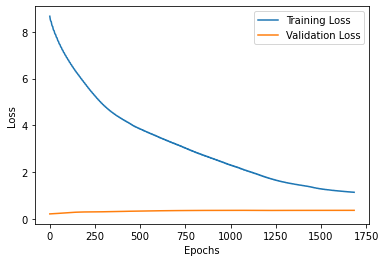

In [65]:
n_epochs = 2000
batch_size = 11
lr = 5e-4
n_features = 3


# Instanciar el modelo con los mismos hiperparametros
model = CompleteNetwork(n_features, max_depth=2, width_multiplier=2)

# De esa manera el training ahora es:
# ---- Training  -----


loss_fn = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                        T_0 = 8,
                                        T_mult = 1,
                                        eta_min = 1e-8)


# ---- Fitting -----
loss_array_training, loss_array_validation = model.fit(X_train_3, y_train, X_valid_3, y_valid, 
    loss_fn, optimizer, scheduler, n_epochs, batch_size, loss_fn2=binary_loss)

# Visualizar los errores
plt.plot(loss_array_training, label='Training Loss')
plt.plot(loss_array_validation, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Precisión: 57.03%
Porcentaje de falsos negativos: 12.81%


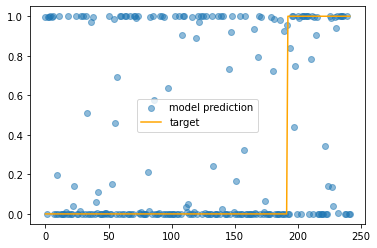

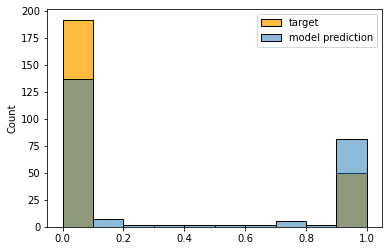

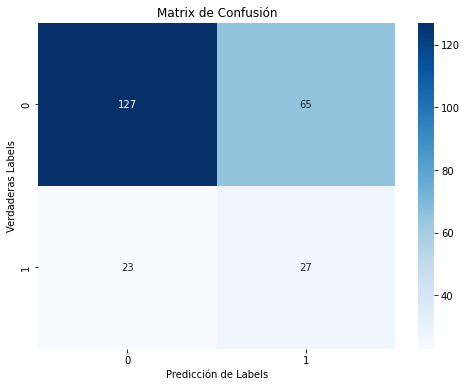

In [66]:
accuracy, false_negatives = calculate_accuracy_and_false_negatives(model, X_test_3, y_test)
print("Precisión: {:.2f}%".format(accuracy))
print("Porcentaje de falsos negativos: {:.2f}%".format(false_negatives))
observe_predictions(X_test_3, y_test, model)
model_confusion_matrix(X_test_3, y_test, model)

El modelo unicamente utilizando BMI, Edad y Embarazos es un poco mejor que adivinar, sin embargo tiene un bajo porcentaje de falsos negativos con un 12%, debido a su función de perdida prefiere sobre predecir la diabetes.

Estas variables por supuesto no son suficientes para entregar toda la información y es posible que el problema radique en una busqueda de hiperparametros mejores.


## Comparando a un RandomForest

In [67]:
# estos son datos sin reescalar, pues será más rapido de interpretar en randomforest
X_train, X_test, X_valid, y_train, y_test, y_valid = get_data(data)

In [79]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [83]:
# Crear una instancia del RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo con tus datos
rf.fit(X_train, y_train)

# Calcular la precisión del modelo en los datos de prueba
accuracy = rf.score(X_test, y_test)

# Imprimir la precisión del modelo
print(f"Precisión del modelo de Random Forest: {accuracy*100:.2f}%")

Precisión del modelo de Random Forest: 3.37%


Luego de ver este estimado se aprecia mucho más la red neuronal

## Hiperparametros

Concentremos esta sección en quedarnos con la red neuronal construida y encontrar hiperparametros optimos

In [89]:
X_train, X_test, X_valid, y_train, y_test, y_valid = get_data(data_selected)

In [91]:
import itertools

# Definir la cuadrícula de valores para los hiperparámetros
param_grid = {
    'n_features': [8, 10, 12],
    'max_depth': [2, 3, 4],
    'width_multiplier': [1, 2, 3],
    'lr': [1e-3, 5e-4, 1e-4],
    'n_epochs': [200, 250, 300],
    'batch_size': [10, 20, 30],
    'loss_fn2_weight': [0.1, 0.2, 0.3]
}

# Obtener todas las combinaciones de valores posibles
param_combinations = list(itertools.product(*param_grid.values()))

best_accuracy = 0.0
best_params = {}

# Iterar sobre todas las combinaciones de valores
for params in param_combinations:
    # Desempaquetar los valores de los hiperparámetros
    n_features, max_depth, width_multiplier, lr, n_epochs, batch_size, loss_fn2_weight = params
    
    # Instanciar el modelo con los hiperparámetros
    model = CompleteNetwork(n_features, max_depth, width_multiplier)
    
    # Definir el optimizador y el programador de la tasa de aprendizaje
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=8, T_mult=1, eta_min=1e-8)
    
    # Entrenar el modelo
    loss_array_training, loss_array_validation = model.fit(X_train, y_train, X_valid, y_valid, 
                                                           loss_fn, optimizer, scheduler, n_epochs, batch_size,
                                                           loss_fn2=binary_loss, loss_fn2_weight=loss_fn2_weight)
    
    # Calcular la precisión del modelo en los datos de prueba
    accuracy, false_negatives = calculate_accuracy_and_false_negatives(model, X_test, y_test)
    print("Precisión: {:.2f}%".format(accuracy))
    print("Porcentaje de falsos negativos: {:.2f}%".format(false_negatives))
    
    # Actualizar los mejores hiperparámetros si se encuentra una mejor precisión
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            'n_features': n_features,
            'max_depth': max_depth,
            'width_multiplier': width_multiplier,
            'lr': lr,
            'n_epochs': n_epochs,
            'batch_size': batch_size,
            'loss_fn2_weight': loss_fn2_weight
        }

# Imprimir los mejores hiperparámetros y la precisión correspondiente
print("Mejores hiperparámetros encontrados:")
print(best_params)
print("Precisión correspondiente:", best_accuracy)
print("Falso negativos", false_negatives)


epoch 0, loss epoch 0.363202303647995
epoch 5, loss epoch 0.1871303766965866
epoch 10, loss epoch 0.09845473617315292
epoch 15, loss epoch 0.07129448652267456
epoch 20, loss epoch 0.04050396382808685
epoch 25, loss epoch 0.030621521174907684
epoch 30, loss epoch 0.022439157590270042
epoch 35, loss epoch 0.014094495214521885
epoch 40, loss epoch 0.010953707620501518
epoch 45, loss epoch 0.007233507931232452
epoch 50, loss epoch 0.00528129655867815
epoch 55, loss epoch 0.00447838194668293
epoch 60, loss epoch 0.0031906471122056246
epoch 65, loss epoch 0.002623689128085971
epoch 70, loss epoch 0.0021876851096749306
epoch 75, loss epoch 0.001754407538101077
epoch 80, loss epoch 0.0015757872024551034
epoch 85, loss epoch 0.0013273623771965504
epoch 90, loss epoch 0.0011507257586345077
epoch 95, loss epoch 0.001057382789440453
epoch 100, loss epoch 0.0008753195288591087
epoch 105, loss epoch 0.0007844347856007516
epoch 110, loss epoch 0.0006913315737619996
epoch 115, loss epoch 0.00057308422

KeyboardInterrupt: 

# Conclusión


Consideresé la conclusión como la siguiente

```
Las variables visibiles son capaces de entregar un buen primer estimado, debido a que las medias estadisticas son diferentes para diabeticas y no diabeticas podria existir una serie de criterios facilmente interpretables.

Sin embargo la tarea de definir estos criterios requiere de un trabajo estadistico y una serie de estudios a distintas poblaciones,

Si tomamos más recursos computacionales seria posible establecer una serie de reglas parametricas que puedan ser entrenables y utilicen test estadisticos junto a minimizar los falsos negativos para así encontrar esta serie de reglas interpretables, pero va más allá del scope de estre proyecto

```